In [87]:
from pyannote.metrics.detection import DetectionErrorRate, DetectionPrecision, DetectionRecall, DetectionPrecisionRecallFMeasure
from pyannote.database.loader import load_rttm
from pyannote.core import Annotation, Segment
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch

In [55]:
annotations = load_rttm("../data/voxconverse-master/dev/afjiv.rttm")
annotation = annotations['afjiv']

In [ ]:
def count_speakers(annotation):
    speakers = set()
    for _, _, speaker in annotation.itertracks(yield_label=True):
        speakers.add(speaker)
    return len(speakers)

5

In [ ]:
for seg in annotation.itersegments():
    print(seg)

[ 00:00:05.280 -->  00:00:34.520]
[ 00:00:34.680 -->  00:00:40.080]
[ 00:00:40.120 -->  00:00:40.960]
[ 00:00:41.120 -->  00:01:20.480]
[ 00:01:20.920 -->  00:01:23.720]
[ 00:01:24.840 -->  00:01:26.080]
[ 00:01:27.080 -->  00:01:28.000]
[ 00:01:28.720 -->  00:01:33.040]
[ 00:01:33.080 -->  00:01:34.360]
[ 00:01:35.120 -->  00:01:38.000]
[ 00:01:38.720 -->  00:01:40.440]
[ 00:01:41.120 -->  00:01:44.600]
[ 00:01:45.560 -->  00:01:47.080]
[ 00:01:47.160 -->  00:01:47.600]
[ 00:01:48.160 -->  00:01:50.040]
[ 00:01:51.000 -->  00:01:53.280]
[ 00:01:53.840 -->  00:01:58.120]
[ 00:01:59.440 -->  00:02:02.320]
[ 00:02:02.960 -->  00:02:04.560]
[ 00:02:05.200 -->  00:02:08.400]
[ 00:02:08.480 -->  00:02:09.640]
[ 00:02:10.880 -->  00:02:13.520]
[ 00:02:13.680 -->  00:02:14.120]
[ 00:02:15.720 -->  00:02:18.160]
[ 00:02:18.920 -->  00:02:20.480]
[ 00:02:20.640 -->  00:02:21.640]
[ 00:02:22.200 -->  00:02:24.320]
[ 00:02:24.600 -->  00:02:25.320]


In [96]:
for path in Path('models').iterdir():
    words = path.as_posix().split('-')
    words.remove(words[-1])
    words[-1] = words[-1] + '.pt'
    new_path = '-'.join(words)
    # print(new_path)
    path.rename(new_path)

In [97]:
def create_annotations(activity_tensor: torch.Tensor, total_frames: int, frames_per_window: int, window_duration: float) -> list[Annotation]:
    """
    Convert speaker activity tensor to pyannote Annotation objects
    
    Args:
        activity_tensor: Tensor of shape (num_speakers, num_frames)
        total_frames: Total number of frames in original audio (13870)
        frames_per_window: Frames per processing window (38)
        window_duration: Duration of each window in seconds (6)
    """
    # Calculate time per frame (constant across all windows)
    frame_duration = window_duration / frames_per_window  # ~0.15789 seconds
    
    # Initialize list to hold Annotation objects
    annotations = Annotation()
    
    # Process each speaker's activity pattern
    for speaker_idx, activity in enumerate(activity_tensor):
        start_frame = None
        
        # Convert tensor to numpy array for easier handling
        activity = activity.numpy()
        
        for frame_idx, active in enumerate(activity):
            if active == 1:
                if start_frame is None:  # Start new segment
                    start_frame = frame_idx
            else:
                if start_frame is not None:  # End current segment
                    # Calculate absolute times in seconds
                    start_time = start_frame * frame_duration
                    end_time = frame_idx * frame_duration
                    annotations[Segment(start_time, end_time)] = f"spk{speaker_idx:02d}"
                    start_frame = None
                    
        # Handle final segment if active at end
        if start_frame is not None:
            start_time = start_frame * frame_duration
            end_time = total_frames * frame_duration
            annotations[Segment(start_time, end_time)] = f"spk{speaker_idx:02d}"
        
        # annotations.append(annotation)
    
    return annotations

In [98]:
model_path = list(Path('models').rglob('*-0-*-100-epochs*.pt'))

results = []
for model in tqdm(model_path):
    activation = torch.load(model, map_location='cpu')
    activation.requires_grad_(False)

    for i in range(1,1000):
        words = model.as_posix().split('-')
        words[1] = str(i)
        new_model = '-'.join(words)
        try:
            activation = torch.cat([activation,torch.load(new_model, map_location='cpu')], dim=-1)
        except Exception as e:
            break

    # print(activation.shape)
    name = model.name.split('-')[0]
    annotation = load_rttm(f"../data/voxconverse-master/dev/{name}.rttm")[name]
    num_speakers = len(annotation.labels())
    relevant_activation = activation[:num_speakers].contiguous()
    pred_annotation = (relevant_activation != 0).long()
    pred_annotation = create_annotations(pred_annotation, pred_annotation.shape[1], 38, 6)
    
    metric = DetectionErrorRate(collar=0.5, skip_overlap=False)
    der = metric(annotation, pred_annotation)
    metric = DetectionPrecision(collar=0.5, skip_overlap=False)
    precision = metric(annotation, pred_annotation)
    metric = DetectionRecall(collar=0.5, skip_overlap=False)
    recall = metric(annotation, pred_annotation)
    metric = DetectionPrecisionRecallFMeasure(collar=0.5, skip_overlap=False)
    F1 = metric(annotation, pred_annotation)
    results.append((der, precision, recall, F1))


  0%|          | 0/216 [00:00<?, ?it/s]/Users/chasezundel/opt/anaconda3/envs/ML/lib/python3.11/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
  0%|          | 1/216 [00:00<01:36,  2.23it/s]/Users/chasezundel/opt/anaconda3/envs/ML/lib/python3.11/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
  1%|          | 2/216 [00:01<03:47,  1.06s/it]/Users/chasezundel/opt/anaconda3/envs/ML/lib/python3.11/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
  1%|▏         | 3/216 [00:02<02:18,  1.54it/s]/Users/chasezundel/opt/anaconda3/envs/ML/lib/python3.11/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  war

In [99]:
res_string = 'Mean ({:.3f}) Min ({:.3f}) Median ({:.3f}) Max ({:.3f}) Stdev ({:.3f}) Var ({:.3f})'

In [100]:
der, precision, recall, F1 = zip(*results)
print('DER:', res_string.format(np.mean(der), np.min(der), np.median(der), np.max(der), np.std(der), np.var(der)), sep='\t')
print('Precision:', res_string.format(np.mean(precision), np.min(precision), np.median(precision), np.max(precision), np.std(precision), np.var(precision)))
print('Recall:', res_string.format(np.mean(recall), np.min(recall), np.median(recall), np.max(recall), np.std(recall), np.var(recall)), sep='\t')
print('F1:', res_string.format(np.mean(F1), np.min(F1), np.median(F1), np.max(F1), np.std(F1), np.var(F1)), sep='\t')

DER:	Mean (1.364) Min (0.866) Median (1.141) Max (19.168) Stdev (1.672) Var (2.797)
Precision: Mean (0.450) Min (0.050) Median (0.465) Max (0.559) Stdev (0.058) Var (0.003)
Recall:	Mean (0.907) Min (0.491) Median (0.937) Max (1.000) Stdev (0.081) Var (0.007)
F1:	Mean (0.598) Min (0.094) Median (0.616) Max (0.666) Stdev (0.067) Var (0.004)


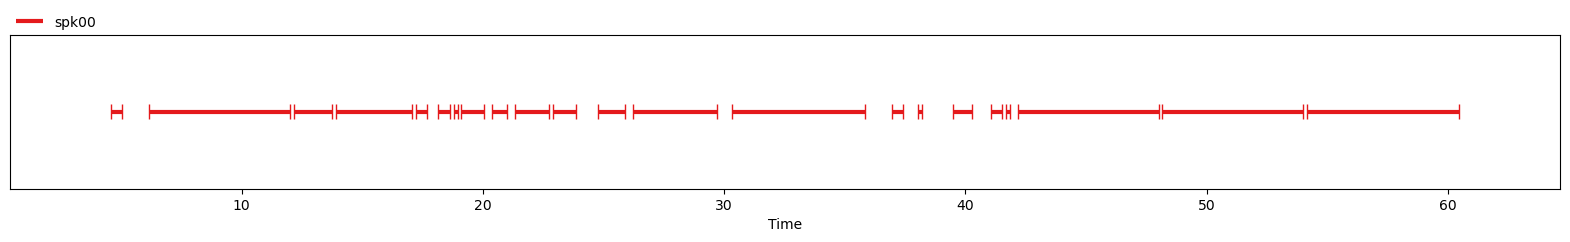

In [101]:
pred_annotation